In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
df0 = pd.read_csv('csv/multi_touch_attribution_data.csv').rename(columns={'User ID':'user_id'})
df0.head()

,user_id,Timestamp,Channel,Campaign,Conversion
0,83281,2025-02-10 07:58:51,Email,New Product Launch,No
1,68071,2025-02-10 23:38:48,Search Ads,Winter Sale,No
2,90131,2025-02-11 10:41:07,Social Media,Brand Awareness,Yes
3,71026,2025-02-10 08:19:44,Direct Traffic,-,Yes
4,94486,2025-02-10 15:15:46,Email,Retargeting,Yes


In [3]:
# generate age and income features using the normal distribution with defined ranges
def normal_dist_feature_gen(df, feature, mean, std_dev, min0, max0):

    a = (min0 - mean) / std_dev
    b = (max0 - mean) / std_dev
    values = truncnorm.rvs(a, b, loc=mean, scale=std_dev, size=df.shape[0])

    df[f'{feature}'] =  np.round(values).astype(int)

    df.hist(column=f'{feature}')
    plt.title(f"Synthetic Distribution for Feature '{feature}'")
    plt.show()

    return df

In [4]:
users = df0['user_id'].unique()
df_users = pd.DataFrame({'user_id': users})

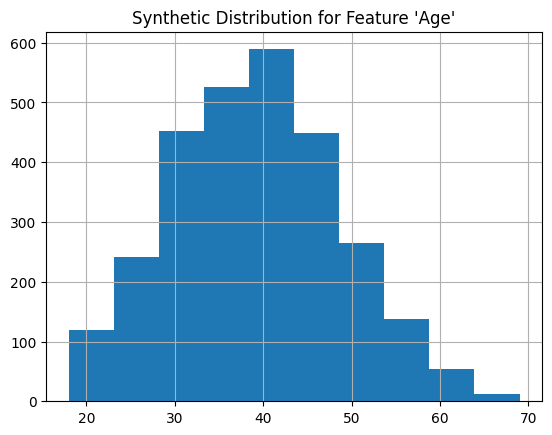

In [5]:
df_users = normal_dist_feature_gen(df=df_users, feature='Age', mean=39, std_dev=10, min0=18, max0=70)

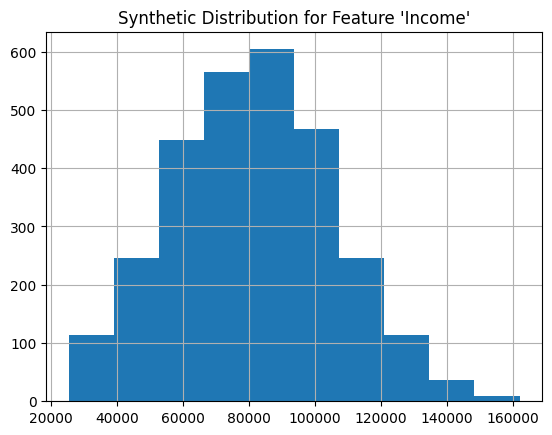

In [6]:
df_users = normal_dist_feature_gen(df=df_users, feature='Income', mean=80000, std_dev=25000, min0=25000, max0=200000)

In [7]:
df1 = df0.merge(df_users, how='left', on = 'user_id')
df1.dtypes

user_id        int64
Timestamp     object
Channel       object
Campaign      object
Conversion    object
Age            int64
Income         int64
dtype: object

In [8]:
df_user_touchpoints = df1.groupby('user_id')['Timestamp'].agg(['count']).reset_index().rename(columns={'count':'count_touchpoints'})

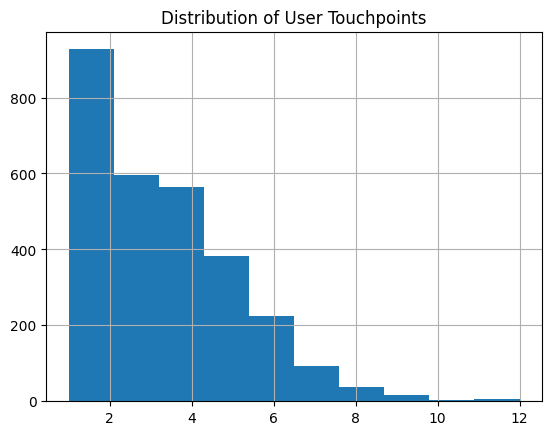

In [9]:
df_user_touchpoints.hist(column='count_touchpoints')
plt.title(f"Distribution of User Touchpoints")
plt.show()

In [10]:
# eoncdoe campaign type
encoder = LabelEncoder()
df1['campaign_touchpoint_id'] = encoder.fit_transform(df1['Campaign'])
df1['channel_id'] = encoder.fit_transform(df1['Channel'])

In [11]:
# create journey_id, but for this use cas all users will only have 1 journey (since this data spans only 2 days)
df1['journey_id'] = 1
df1['converted'] = np.where(df1['Conversion']=='Yes', True, False)

df1 = df1.sort_values(by=['user_id', 'Timestamp'])

df1[df1.user_id==10045].head()

,user_id,Timestamp,Channel,Campaign,Conversion,Age,Income,campaign_touchpoint_id,channel_id,journey_id,converted
9486,10045,2025-02-10 17:20:43,Search Ads,Discount Offer,No,33,38210,2,4,1,False
7663,10045,2025-02-11 18:44:15,Display Ads,New Product Launch,Yes,33,38210,3,1,1,True


In [12]:
df1[['Campaign','campaign_touchpoint_id']].drop_duplicates().sort_values('campaign_touchpoint_id')

,Campaign,campaign_touchpoint_id
3633,-,0
8643,Brand Awareness,1
8297,Discount Offer,2
7663,New Product Launch,3
8457,Retargeting,4
663,Winter Sale,5


In [13]:
df1[['Channel','channel_id']].drop_duplicates().sort_values('channel_id')

,Channel,channel_id
7029,Direct Traffic,0
3633,Display Ads,1
1967,Email,2
8407,Referral,3
8297,Search Ads,4
8643,Social Media,5


### Modeling

In [ ]:
#TODO: Concat campaign and channel combinations then predict best sequence of those touchpoints

In [14]:
max_length = df1.groupby('user_id')['Timestamp'].count().max()

In [15]:
num_touchpoints = len(df1.groupby(['Campaign']))
num_touchpoints

6

In [16]:
num_channels = len(df1.groupby(['Channel']))
num_channels

6

In [23]:
journeys = df1.groupby(['user_id','journey_id']).agg(
    campaign_list = ('campaign_touchpoint_id', lambda x: x.tolist() + [num_touchpoints] * (max_length - len(x))),
    channel_list = ('channel_id', lambda x: x.tolist() + [num_channels] * (max_length - len(x))),
    converted = ('converted', 'any'),
    age = ('Age', 'min'),
    income = ('Income', 'min')
).reset_index()

In [24]:
journeys[:5]

,user_id,journey_id,campaign_list,channel_list,converted,age,income
0,10028,1,"[2, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]","[4, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",True,31,44998
1,10045,1,"[2, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]","[4, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",True,33,38210
2,10062,1,"[1, 0, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6]","[5, 0, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6]",True,43,84907
3,10068,1,"[0, 4, 1, 3, 5, 6, 6, 6, 6, 6, 6, 6]","[4, 5, 5, 4, 5, 6, 6, 6, 6, 6, 6, 6]",True,38,111811
4,10095,1,"[4, 4, 3, 0, 4, 0, 6, 6, 6, 6, 6, 6]","[1, 2, 3, 1, 4, 3, 6, 6, 6, 6, 6, 6]",True,36,119416


In [25]:
journeys.groupby('converted').agg({'user_id':'nunique'})

,user_id
converted,
False,466
True,2381


In [26]:
y = torch.tensor(df1.groupby(['user_id','journey_id']).agg(
    converted = ('converted', 'any')
).converted.values, dtype=torch.float)

# journeys = journeys.merge(user_df, on='user_id')
y

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [27]:
class JourneyLSTM(nn.Module):
    def __init__(self, extra_dim:int, journey_dim:int, num_channels: int, hidden_size: int = 64, num_layers: int = 2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.journey_dim = journey_dim
        self.extra_dim = extra_dim
        
        # Embedding layer for channel types
        self.channel_embedding = nn.Embedding(num_channels+1, hidden_size, padding_idx=num_channels)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size + extra_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x:torch.Tensor, lengths=None):
        # x shape: (batch_size, seq_length)
        # Embed channels
        embedded = self.channel_embedding(x[:, -self.journey_dim:].long())  # (batch_size, seq_length, hidden_size)
        
        if lengths is not None:
            # Pack padded sequence
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths, batch_first=True, enforce_sorted=False
            )
            # Process through LSTM
            lstm_out, _ = self.lstm(packed)
            # Unpack
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        else:
            lstm_out, _ = self.lstm(embedded)
        
        # Get final output
        final_hidden = lstm_out[:, -1, :]  # Take last timestep
        out = self.sigmoid(self.fc(torch.cat((final_hidden, x[:, :-self.journey_dim]), dim=1)))
        return out

In [29]:
journeys.channel_list

0       [4, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
1       [4, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
2       [5, 0, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6]
3       [4, 5, 5, 4, 5, 6, 6, 6, 6, 6, 6, 6]
4       [1, 2, 3, 1, 4, 3, 6, 6, 6, 6, 6, 6]
                        ...                 
2842    [1, 5, 4, 3, 2, 6, 6, 6, 6, 6, 6, 6]
2843    [2, 0, 0, 4, 1, 6, 6, 6, 6, 6, 6, 6]
2844    [3, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
2845    [1, 3, 1, 0, 0, 1, 6, 6, 6, 6, 6, 6]
2846    [3, 4, 3, 1, 2, 4, 6, 6, 6, 6, 6, 6]
Name: channel_list, Length: 2847, dtype: object

In [30]:
# define model target as 'channel_list'

transformer = ColumnTransformer(transformers=[
    ('num_scaler', StandardScaler(), ['age','income'])
])

X = torch.tensor(transformer.fit_transform(journeys), dtype=torch.float)
X_journey = torch.tensor(np.stack(journeys.channel_list), dtype=torch.long)

journey_dim = X_journey.shape[1]

In [31]:
X = torch.cat((X, X_journey), dim=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=12)

In [33]:
# num_channels = len(generator.touchpoints)
extra_dim = X_train.shape[1] - journey_dim
model = JourneyLSTM(num_channels=num_touchpoints, journey_dim=journey_dim, extra_dim=extra_dim)

loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64)

In [35]:
test_recalls = []

n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        # Training metrics
        y_pred = model(X_train)
        y_pred_round = y_pred.round()
        train_acc = (y_pred_round == y_train).float().mean()
        train_recall = ((y_pred_round == 1) & (y_train == 1)).sum() / (y_train == 1).sum()

        # Test metrics
        y_pred = model(X_test)
        y_pred_round = y_pred.round()
        test_acc = (y_pred_round == y_test).float().mean()
        test_recall = ((y_pred_round == 1) & (y_test == 1)).sum() / (y_test == 1).sum()
        test_recalls.append(test_recall)
        

    print("Epoch %d: train acc %.4f, train recall %.4f, test acc %.4f, test recall %.4f" % 
          (epoch, train_acc, train_recall, test_acc, test_recall))

Epoch 0: train acc 0.8406, train recall 1.0000, test acc 0.8193, test recall 1.0000
Epoch 10: train acc 0.8415, train recall 0.9943, test acc 0.8246, test recall 0.9936
Epoch 20: train acc 0.8415, train recall 0.9922, test acc 0.8263, test recall 0.9914
Epoch 30: train acc 0.8406, train recall 0.9875, test acc 0.8298, test recall 0.9936
Epoch 40: train acc 0.8410, train recall 0.9822, test acc 0.8333, test recall 0.9893


In [37]:
# create dictionary of touchpoint mappings like: {0: 'email', 1: 'social', 2: 'search', 3: 'retargeting', 4: 'direct'}
touchpoint_id_mapping = {row['channel_id']: row['Channel'] for row in df1.to_dict(orient='records')}
touchpoint_id_mapping

{4: 'Search Ads',
 1: 'Display Ads',
 5: 'Social Media',
 0: 'Direct Traffic',
 2: 'Email',
 3: 'Referral'}

Text(0, 0.5, 'Recall')

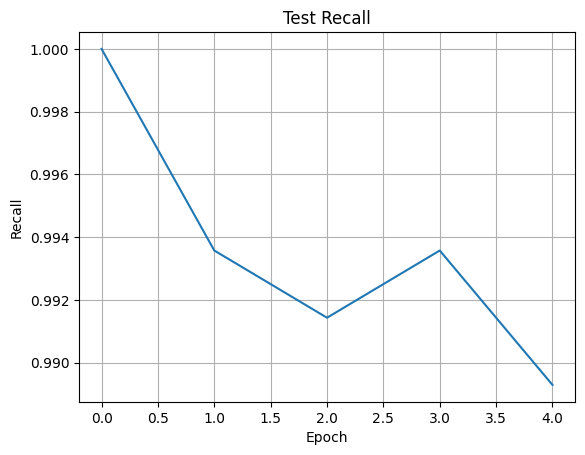

In [38]:
test_recalls = np.array(test_recalls)

fig, ax = plt.subplots()
sns.lineplot(x=np.arange( n_epochs / 10), y=test_recalls, ax=ax)
ax.set_title('Test Recall')
ax.set_xlabel('Epoch')
ax.grid()
ax.set_ylabel('Recall')

#### TODO: test recall going down while epochs increase indicates overfitting. Need better data.

## Optimization

In [39]:
def apply_constraints(journeys:pd.DataFrame, constraints:dict, target):
    journeys_c = journeys.copy()
    imposed_journey_list = np.array([ [num_touchpoints] * (max_length)] * len(journeys))

    for pos, channel in constraints.items():
        imposed_journey_list[:, pos] = channel
    imposed_journey_list = imposed_journey_list.tolist()
    journeys_c['imposed_journey_list'] = imposed_journey_list
    journeys_c.drop(columns=['channel_list'], inplace=True)
    return journeys_c

In [40]:
custom_set = journeys.sample(25)
constraints = {0:0}
custom_set = apply_constraints(custom_set, constraints)

X_custom = torch.tensor(transformer.transform(custom_set), dtype=torch.float)
X_custom_journey = torch.tensor(np.stack(custom_set.imposed_journey_list), dtype=torch.long)
X_custom = torch.cat((X_custom, X_custom_journey), dim=1)
custom_set['pred_conv_prob'] = model(X_custom).detach().numpy().flatten()

KeyError: "['journey_list'] not found in axis"

In [ ]:
def beam_search_step(
        model: JourneyLSTM, 
        X: torch.Tensor, 
        pos: int, 
        num_channels: int, 
        max_length: int, 
        constraints:dict[int, int], 
        beam_width: int = 5
    ):
    if pos > max_length:
        return X
    
    if pos in constraints:
        return beam_search_step(model, X, pos + 1, num_channels, max_length, constraints, beam_width)
    
    candidates = []  # List to store (sequence, score) tuples
    
    for sequence_idx in range(min(beam_width, len(X))):
        X_current = X[sequence_idx:sequence_idx+1].clone()
        
        # Try each possible channel
        for channel in range(num_channels):
            X_candidate = X_current.clone()
            X_candidate[0, extra_dim + pos] = channel
            
            # Get prediction score
            pred = model(X_candidate)[0].item()
            candidates.append((X_candidate, pred))
    
    candidates.sort(key=lambda x: x[1], reverse=True)
    best_candidates = candidates[:beam_width]
    
    X_next = torch.cat([cand[0] for cand in best_candidates], dim=0)
    
    # Recurse with best candidates
    return beam_search_step(model, X_next, pos + 1, num_channels, max_length, constraints, beam_width)

In [ ]:
start_sequence = X_custom[0:1]  # Start with single sequence
result = beam_search_step(model, start_sequence, pos=0, num_channels=num_touchpoints, max_length=3, constraints=constraints)

for i in range(len(result)):
    journey = result[i, extra_dim:extra_dim+4].int().tolist()
    print(journey)
    channel_names = [touchpoint_id_mapping[c] for c in journey if c < num_touchpoints]
    pred = model(result[i:i+1]).item()
    print(f"Sequence {i+1}: {channel_names}, Score: {pred:.4f}")